run from py38 environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import optimize
import SimpleITK as sitk
from scipy.fft import fftfreq, fft
from sklearn.decomposition import PCA, FastICA

In [2]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', labelsize=15) 
#plt.rc('title', labelsize=15) 

# Functions

In [3]:
def extract_residuals_roi(phantom_epi, roi, num_rep):
    num_dummy_scans = round(num_rep*0.013)
    num_rep_no_dummy = num_rep - num_dummy_scans
    time = np.linspace(0, num_rep_no_dummy-1, num_rep_no_dummy)
    
    #iterate over different roi sizes (the original has dimensions 6,6,8)
    #############################################################################################
    #extract only the voxels in the ROI
    l=[]
    for i in range(phantom_epi.shape[0]): #iterate over timepoints
        l.append(phantom_epi[i,roi.astype(bool)])
    phantom_epi_roi = np.array(l)
    
    ###############################################################################################
    # Obtain residuals within each roi
    
    #first fit the second order polynomial to the data
    phantom_epi_roi_mean = np.mean(phantom_epi_roi, axis = 1) #gives mean across voxels, at each timepoint
    model_roi = np.polyfit(time, phantom_epi_roi_mean, 2)
    predicted_roi = np.polyval(model_roi,time)
    residuals_roi = phantom_epi_roi_mean - predicted_roi
    
    timeseries_mean = np.mean(phantom_epi_roi_mean)
    
    return residuals_roi,timeseries_mean, phantom_epi_roi_mean, predicted_roi

In [4]:
def voxelwise_wholephantom_analysis(phantom_epi_full, slice_num, slices, dimension1, dimension2, num_rep):
    num_dummy_scans = round(num_rep*0.013)
    num_rep_no_dummy = num_rep - num_dummy_scans
    ############################################## DISCARD FIRST 5 VOLUMES ######################
    phantom_epi = phantom_epi_full[num_dummy_scans:num_rep,:,:,:]
    ################################################################################################
    #calculate signal image (average across the timepoints, voxel-wise)
    signal_image = np.mean(phantom_epi, axis = 0)
    
    ###############################################################################################
    #calculate the temporal fluctuation noise image (std of residuals after detrending timeseries with 2nd order polynomial)
    
    #first fit the second order polynomial to the data
    time = np.linspace(0, num_rep_no_dummy-1, num_rep_no_dummy)
    phantom_epi_flat = phantom_epi.transpose(1,2,3,0).reshape(-1,phantom_epi.shape[0])
    model = np.polyfit(time, phantom_epi_flat.T, 2)
    model_image = model.reshape(3,slices,dimension1,dimension2)
    
    #generate the predicted polynomial curve based on the fitted model(for each voxel)
    tot_vox = slices*dimension1*dimension2
    predicted = np.zeros([tot_vox,num_rep_no_dummy])
    for i in range(0,tot_vox):
        predicted[i,:] = np.polyval(model[:,i],time)
        
    #detrend the data by removing second order polynomial
    phantom_epi_flat_detrended = phantom_epi_flat - predicted
    phantom_epi_detrended = phantom_epi_flat_detrended.reshape(slices,dimension1,dimension2,num_rep_no_dummy)
    
    temp_fluc_noise_image = np.std(phantom_epi_detrended, axis = 3)
    
    ############################################################################################
    #compute signal to fluctuation noise ratio (SFNR)
    sfnr_image = signal_image/temp_fluc_noise_image
    
    ###########################################################################################
    #compute static spatial noise image
    sumeven = 0
    sumodd = 0
    for i in range(0,num_rep_no_dummy-1,2):
        sumeven = sumeven + phantom_epi[i,:,:,:]
        sumodd = sumodd + phantom_epi[i+1,:,:,:]
    static_spatial_noise_im = sumodd - sumeven

    ################################### PLOT ##########################################################3
    fig, axs = plt.subplots(1, 7, figsize = (17,6))
    s = axs[0].imshow(signal_image[slice_num,:,:], origin = 'lower')
    cbar = plt.colorbar(s, ax = axs[0], orientation = 'horizontal')
    axs[0].set_title('Signal Image')
    axs[1].set_title('Temporal Fluctuation Noise Image')
    t = axs[1].imshow(temp_fluc_noise_image[slice_num,:,:], origin = 'lower')
    cbar = plt.colorbar(t, ax = axs[1], orientation = 'horizontal')
    axs[2].set_title('SFNR Image')
    sf = axs[2].imshow(sfnr_image[slice_num,:,:], origin = 'lower')
    cbar = plt.colorbar(sf, ax = axs[2], orientation = 'horizontal')
    axs[3].set_title('Static Spatial Noise Image')
    g = axs[3].imshow(static_spatial_noise_im[slice_num,:,:], origin = 'lower')
    cbar = plt.colorbar(g, ax = axs[3], orientation = 'horizontal')
    axs[4].set_title('Drift model, order 2')
    g = axs[4].imshow(model_image[0,slice_num,:,:], origin = 'lower')
    cbar = plt.colorbar(g, ax = axs[4], orientation = 'horizontal')
    axs[5].set_title('Drift model, order 1')
    g = axs[5].imshow(model_image[1,slice_num,:,:], origin = 'lower')
    cbar = plt.colorbar(g, ax = axs[5], orientation = 'horizontal')
    axs[6].set_title('Drift model, order 0')
    g = axs[6].imshow(model_image[2,slice_num,:,:], origin = 'lower')
    cbar = plt.colorbar(g, ax = axs[6], orientation = 'horizontal')
    
    fig.tight_layout()
    plt.show()
    
    
    return signal_image, sfnr_image, static_spatial_noise_im, phantom_epi_flat_detrended, model_image

In [5]:
def roi_residuals_analysis(phantom_epi_full, roi, signal_image, sfnr_image, static_spatial_noise_im, TR, num_rep):
    num_dummy_scans = round(num_rep*0.013)
    num_rep_no_dummy = num_rep - num_dummy_scans
    phantom_epi = phantom_epi_full[num_dummy_scans:num_rep,:,:,:]
    time = np.linspace(0, num_rep_no_dummy-1, num_rep_no_dummy)
    residuals_in_roi, timeseries_mean, phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi, num_rep)
    
    ###################################### CALC METRICS WITHIN ROI #######################################3
    signal_summary_value = np.mean(signal_image[roi.astype(bool)])
    sfnr_summary_value = np.mean(sfnr_image[roi.astype(bool)])
    intrinsic_noise = np.var(static_spatial_noise_im[roi.astype(bool)])
    snr = signal_summary_value/np.sqrt(intrinsic_noise/355)
    
    percent_fluc = 100*np.std(residuals_in_roi)/np.mean(phantom_epi_roi_mean)
    drift = 100*(max(residuals_in_roi)- min(residuals_in_roi))/np.mean(phantom_epi_roi_mean) #not sure if this is right
    drift_alt = 100*(max(predicted_roi)- min(predicted_roi))/signal_summary_value
    diff = max(predicted_roi)- min(predicted_roi)
    
    ####################################### Fourier Analysis ####################################################
    N = phantom_epi.shape[0] #length
    T = TR #sample spacing (in s)

    yf = scipy.fft.fft(residuals_in_roi)
    yf_half = np.abs(yf[1:(N+1)//2])
    xf = scipy.fft.fftfreq(N, T)[1:(N+1)//2]
    location_of_peak = np.argwhere(yf_half > max(yf_half) - 1)
    value_of_peak = xf[location_of_peak]
    
    ########################################difference with Gaussian (qq correlation)#############################
    (osm, osr),(slope, intercept, r) = stats.probplot(residuals_in_roi)
    
    ##################################### PLOT ##################################################################
    fig, axs = plt.subplots(1, 5, figsize = (20,4))
    axs[0].set_title('Polynomial Fit (ROI average)', fontsize=15)
    axs[0].plot(time, phantom_epi_roi_mean)
    axs[0].plot(time, predicted_roi)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal Intensity')
    axs[1].set_title('Residuals', fontsize=15)
    axs[1].plot(time, residuals_in_roi)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal Intensity')
    axs[2].set_title('FFT Spectrum', fontsize=15)
    axs[2].plot(xf, np.abs(yf[1:(N+1)//2]))
    axs[2].set_xlabel('Frequency (Hz)')
    axs[2].set_ylabel('FFT Magnitude')
    axs[3].set_title('Histogram of Residuals', fontsize=15)
    axs[3].hist(residuals_in_roi, bins = 30)
    axs[3].set_xlabel('Residual intensity')
    axs[3].set_ylabel('Frequency')
    stats.probplot(residuals_in_roi, plot=axs[4])
    print(r)
    fig.tight_layout()
    plt.show()
    
    return sfnr_summary_value, snr, percent_fluc, drift_alt, value_of_peak

In [6]:
def weisskoff_analysis(phantom_epi_full, roi1, roi2, roi3, roi4, roi5, roi6, roi7, roi8, roi9, roi10, roi11, roi12, roi13, roi14, num_rep):
    num_dummy_scans = round(num_rep*0.013)
    num_rep_no_dummy = num_rep - num_dummy_scans
    
    phantom_epi = phantom_epi_full[num_dummy_scans:num_rep,:,:,:]
    
    #extract residuals from each roi size
    residuals_arr = np.zeros([num_rep_no_dummy,14])
    mean_arr = np.zeros(14)
    residuals_arr[:,0], mean_arr[0], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi1, num_rep)
    residuals_arr[:,1], mean_arr[1], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi2, num_rep)
    residuals_arr[:,2], mean_arr[2], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi3, num_rep)
    residuals_arr[:,3], mean_arr[3], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi4, num_rep)
    residuals_arr[:,4], mean_arr[4], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi5, num_rep)
    residuals_arr[:,5], mean_arr[5], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi6, num_rep)
    residuals_arr[:,6], mean_arr[6], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi7, num_rep)
    residuals_arr[:,7], mean_arr[7], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi8, num_rep)
    residuals_arr[:,8], mean_arr[8], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi9, num_rep)
    residuals_arr[:,9], mean_arr[9], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi10, num_rep)
    residuals_arr[:,10], mean_arr[10], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi11, num_rep)
    residuals_arr[:,11], mean_arr[11], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi12, num_rep)
    residuals_arr[:,12], mean_arr[12], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi13, num_rep)
    residuals_arr[:,13], mean_arr[13], phantom_epi_roi_mean, predicted_roi = extract_residuals_roi(phantom_epi, roi14, num_rep)
    
    #calculate coefficient of variation of each residual
    cv_arr = np.zeros(14)
    num_voxels = np.zeros(14)
    for i in range(0,14):
        cv_arr[i] = np.std(residuals_arr[:,i])/mean_arr[i]
        num_voxels[i] = i+1
        
    #plot the curve
    plt.figure()
    plt.plot(num_voxels, 100*cv_arr, 'o',label = 'Measured')
    plt.plot(num_voxels, num_voxels**(-1/2), 'o',label = 'Theoretical')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('ROI Width')
    plt.ylabel('100*Coefficient of Variation')
    plt.legend()
    plt.show()
    
    return cv_arr, num_voxels

In [7]:
def calc_ghosting_level(phantom_epi_full, phantom_mask, dimension_along_PE, num_rep, TR):
    num_dummy_scans = round(num_rep*0.013)
    num_rep_no_dummy = num_rep - num_dummy_scans
    phantom_epi = phantom_epi_full[num_dummy_scans:num_rep,:,:,:]
    
    pixel_shift = round(dimension_along_PE/2) #N/2 ghosts are shifted by N/2 pixels
    phantom_mask_rolled = np.roll(phantom_mask, pixel_shift, axis=1)
    
    ghost_mask = phantom_mask_rolled - phantom_mask  #subtract the original mask from the rolled mask to get pixels outside the agar
    below_threshold_indices = ghost_mask < 0.99
    ghost_mask[below_threshold_indices] = 0     #set all pixels outside agar to zero
    
    ghosting_level_per_rep = np.zeros(num_rep_no_dummy)
    for i in range(0, num_rep_no_dummy):
        epi_ghosts = np.multiply(phantom_epi[i,:,:,:], ghost_mask)
        ghosting_level_per_rep[i] = epi_ghosts[epi_ghosts!= 0.00].mean()   #get mean of non zero values inside the ghost mask
        
        ####################################### Fourier Analysis ####################################################
    N = phantom_epi.shape[0] #length
    T = TR #sample spacing (in s)

    yf = scipy.fft.fft(ghosting_level_per_rep)
    yf_half = np.abs(yf[1:(N+1)//2])
    xf = scipy.fft.fftfreq(N, T)[1:(N+1)//2]
    location_of_peak = np.argwhere(yf_half > max(yf_half) - 1)
    value_of_peak = xf[location_of_peak]
    
    fig, axs = plt.subplots(1, 3, figsize = (18,4))
    time = np.linspace(0, num_rep_no_dummy-1, num_rep_no_dummy)
    plot = axs[0].plot(time, ghosting_level_per_rep)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Mean voxel intensity in Nyquist ghost')
    axs[0].set_title('Ghosting level across time')
    im = axs[2].imshow(epi_ghosts[13,:,:], origin = 'lower')
    cbar = plt.colorbar(im, ax = axs[2], orientation = 'vertical')
    axs[2].set_title('Ghosting image')
    axs[1].set_title('FFT Spectrum inside ghost')
    axs[1].plot(xf, np.abs(yf[1:(N+1)//2]))
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('FFT Magnitude')
    plt.show()
    
    return ghosting_level_per_rep

# Section 1: Preliminary analysis of phantom 002 

## Try different ROI locations and various slices, to confirm that the results hold

**a) Load data and ROIs**

In [8]:
#load the EPI
agar_epi_image = sitk.ReadImage("./phantom_002/sub-agar002_ses-2_rest_acq-EPI_bold.nii.gz")
agar_epi = sitk.GetArrayFromImage(agar_epi_image)

In [104]:
#load rois
roi_image_large = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice.mnc")
roi_large = sitk.GetArrayFromImage(roi_image_large)
roi_large = roi_large.swapaxes(0,1)

roi_image_upper = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_upper_nobubble.mnc")
roi_upper = sitk.GetArrayFromImage(roi_image_upper)
roi_upper = roi_upper.swapaxes(0,1)

roi_image_upperb = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_upper.mnc")
roi_upperb = sitk.GetArrayFromImage(roi_image_upperb)
roi_upperb = roi_upperb.swapaxes(0,1)

roi_image_lower = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_lower.mnc")
roi_lower = sitk.GetArrayFromImage(roi_image_lower)
roi_lower = roi_lower.swapaxes(0,1)

roi_image_large2 = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice2.mnc")
roi_large2 = sitk.GetArrayFromImage(roi_image_large2)
roi_large2 = roi_large2.swapaxes(0,1)

roi_image_upper2 = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice2_upper.mnc")
roi_upper2 = sitk.GetArrayFromImage(roi_image_upper2)
roi_upper2 = roi_upper2.swapaxes(0,1)

roi_image_lower2 = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice2_lower.mnc")
roi_lower2 = sitk.GetArrayFromImage(roi_image_lower2)
roi_lower2 = roi_lower2.swapaxes(0,1)

roi_image_large3 = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice3.mnc")
roi_large3 = sitk.GetArrayFromImage(roi_image_large3)
roi_large3 = roi_large3.swapaxes(0,1)

roi_image_upper3 = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice3_upper.mnc")
roi_upper3 = sitk.GetArrayFromImage(roi_image_upper3)
roi_upper3 = roi_upper3.swapaxes(0,1)

roi_image_lower3 = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice3_lower.mnc")
roi_lower3 = sitk.GetArrayFromImage(roi_image_lower3)
roi_lower3 = roi_lower3.swapaxes(0,1)

roi_image_sumslice = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square.mnc")
roi_sumslice = sitk.GetArrayFromImage(roi_image_sumslice)
roi_sumslice = roi_sumslice.swapaxes(0,1)

In [105]:
#load rois of different sizes for the weisskoff analysis
roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_1x1.mnc")
roi_large_1x1 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_2x2.mnc")
roi_large_2x2 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_3x3.mnc")
roi_large_3x3 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_4x4.mnc")
roi_large_4x4 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_5x5.mnc")
roi_large_5x5 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_6x6.mnc")
roi_large_6x6 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_7x7.mnc")
roi_large_7x7 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_8x8.mnc")
roi_large_8x8 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_9x9.mnc")
roi_large_9x9 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_10x10.mnc")
roi_large_10x10 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_11x11.mnc")
roi_large_11x11 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_12x12.mnc")
roi_large_12x12 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_13x13.mnc")
roi_large_13x13 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

roi_image = sitk.ReadImage("./phantom_002/roi_agar002_downsampled_square_oneslice_14x14.mnc")
roi_large_14x14 = sitk.GetArrayFromImage(roi_image).swapaxes(0,1)

**b) Whole phantom analysis for 002**

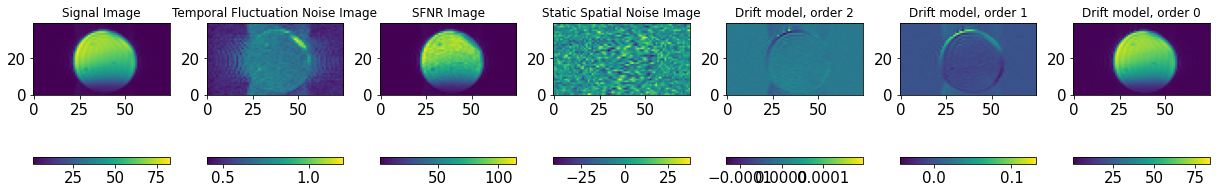

In [106]:
signal_image, sfnr_image, static_spatial_noise_im, agar_epi_flat_detrended, model_image = voxelwise_wholephantom_analysis(agar_epi, 15, 26, 40, 75, 360)

**c) Analysis within ROI spanning multiple slices**

0.9966802022489949


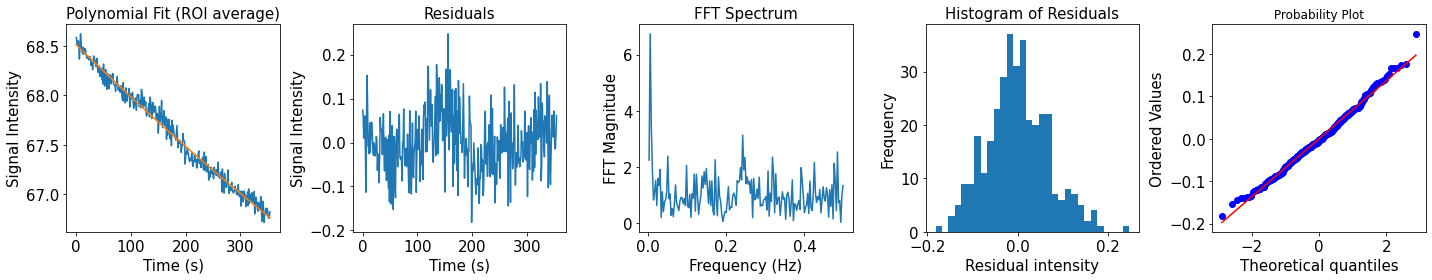

The SFNR summary value (inside roi) is: 92.95016785047672
The SNR summary value (inside roi) is: 89.66660397970234
The Percent fluctuation (inside roi) is: 0.10057593543823701
The drift (inside roi) is: 2.5842449415829067
The strongest frequency is: [[0.0056338]]


In [109]:
sfnr_summary_value_sumslice, snr_sumslice, percent_fluc_sumslice, drift_sumslice, peak_value_sumslice = roi_residuals_analysis(agar_epi, roi_sumslice, signal_image, sfnr_image, static_spatial_noise_im, 1.0, 360)
print("The SFNR summary value (inside roi) is:", sfnr_summary_value_sumslice)
print("The SNR summary value (inside roi) is:", snr_sumslice)
print("The Percent fluctuation (inside roi) is:", percent_fluc_sumslice)
print("The drift (inside roi) is:", drift_sumslice)
print("The strongest frequency is:", peak_value_sumslice)

**1. d) Analysis within large ROIs (each from a different slice)** 

In [88]:
pca = PCA()
pc_space_sliceselectdir_13slices = pca.fit_transform(agar_epi_flat_detrended_sliceselectdir_13slices)
pc_time_sliceselectdir_13slices = pca.components_

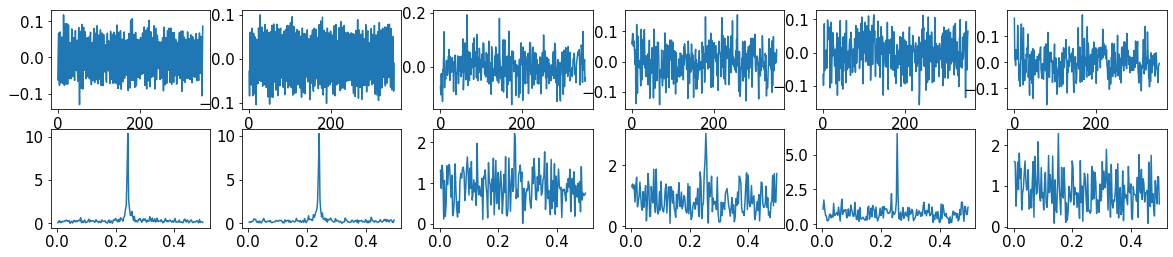

In [89]:
fig, axs = plt.subplots(2, 6, figsize = (20,4))

#plot timecourses of each pc_time_sliceselectdir in first row
time_axis = np.linspace(0, 354, 355)
axs[0,0].plot(time_axis,pc_time_sliceselectdir[0,:])
axs[0,1].plot(time_axis,pc_time_sliceselectdir[1,:]) #this is likely the right candidate
axs[0,2].plot(time_axis,pc_time_sliceselectdir[2,:])
axs[0,3].plot(time_axis,pc_time_sliceselectdir[3,:])
axs[0,4].plot(time_axis,pc_time_sliceselectdir[4,:])
axs[0,5].plot(time_axis,pc_time_sliceselectdir[5,:])

#plot fourier transform of each pc_time_sliceselectdir in second row
N = 360
T = 1.0
xf = scipy.fft.fftfreq(N, T)[1:(N+1)//2]
axs[1,0].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir[0,:])[1:(N+1)//2]))
axs[1,1].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir[1,:])[1:(N+1)//2])) #at index 85, has frequency of 0.2422
axs[1,2].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir[2,:])[1:(N+1)//2]))
axs[1,3].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir[3,:])[1:(N+1)//2]))
axs[1,4].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir[4,:])[1:(N+1)//2]))
axs[1,5].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir[5,:])[1:(N+1)//2]))

plt.show()

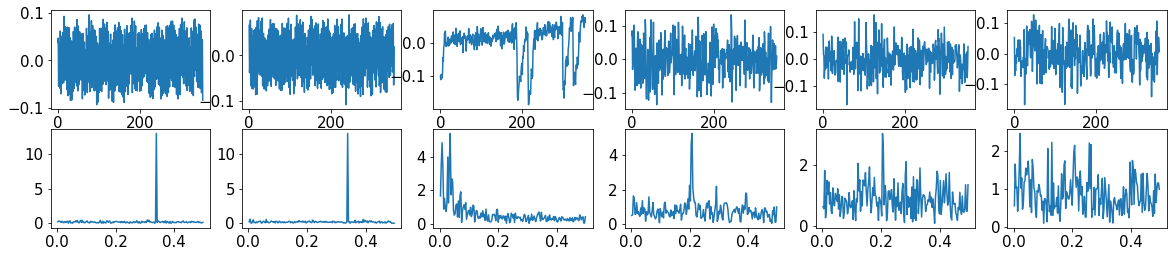

In [90]:
fig, axs = plt.subplots(2, 6, figsize = (20,4))

#plot timecourses of each pc_time_sliceselectdir_13slices in first row
time_axis = np.linspace(0, 354, 355)
axs[0,0].plot(time_axis,pc_time_sliceselectdir_13slices[0,:])
axs[0,1].plot(time_axis,pc_time_sliceselectdir_13slices[1,:]) #this is likely the right candidate
axs[0,2].plot(time_axis,pc_time_sliceselectdir_13slices[2,:])
axs[0,3].plot(time_axis,pc_time_sliceselectdir_13slices[3,:])
axs[0,4].plot(time_axis,pc_time_sliceselectdir_13slices[4,:])
axs[0,5].plot(time_axis,pc_time_sliceselectdir_13slices[5,:])

#plot fourier transform of each pc_time_sliceselectdir_13slices in second row
N = 360
T = 1.0
xf = scipy.fft.fftfreq(N, T)[1:(N+1)//2]
axs[1,0].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir_13slices[0,:])[1:(N+1)//2]))
axs[1,1].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir_13slices[1,:])[1:(N+1)//2])) #at index 85, has frequency of 0.2422
axs[1,2].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir_13slices[2,:])[1:(N+1)//2]))
axs[1,3].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir_13slices[3,:])[1:(N+1)//2]))
axs[1,4].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir_13slices[4,:])[1:(N+1)//2]))
axs[1,5].plot(xf, np.abs(scipy.fft.fft(pc_time_sliceselectdir_13slices[5,:])[1:(N+1)//2]))

plt.show()

In [ ]:
fig, axs = plt.subplots(4, 7, figsize = (20,10))
pc_space_im = pc_space.reshape(26,40,75,10)
slice_num = 0
for i in range(0,4):
    for j in range(0,7):
        axs[i,j].imshow(pc_space_im[slice_num,:,:,1])
        axs[i,j].set_title(slice_num)
        slice_num = slice_num + 1
